<a href="https://colab.research.google.com/github/daj10/Seg-IRM-SimpleITK/blob/main/Seg_img_SimpleITK.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Segmentation d'image avec Python et SimpleITK Couche d'abstraction sur la bibliothèque ITK** 


> segmentation semi-automatique de la matière cérébrale (blanche et grise) à partir d'un ensemble de données IRM


---

* Chargement d'une série de fichiers DICOM, 

* Application des techniques de lissage / débruitage d'image, les filtres d'image de croissance de région, le remplissage de trous binaires, ainsi que des astuces de visualisation.
* Segmenter / étiqueter la matière blanche et grise à partir d'un ensemble de données IRM.




In [45]:
pip install SimpleITK

## Importations

In [46]:
import os
import numpy
import SimpleITK
import matplotlib.pyplot as plt
%pylab inline

Populating the interactive namespace from numpy and matplotlib


## Fonctions d'assistance


> fonction pour tracer rapidement une image 2D SimpleITK avec une palette de couleurs en niveaux de gris et les axes associés




In [47]:
def sitk_show(img, title=None, margin=0.05, dpi=40 ):
    nda = SimpleITK.GetArrayFromImage(img)
    spacing = img.GetSpacing()
    figsize = (1 + margin) * nda.shape[0] / dpi, (1 + margin) * nda.shape[1] / dpi
    extent = (0, nda.shape[1]*spacing[1], nda.shape[0]*spacing[0], 0)
    fig = plt.figure(figsize=figsize, dpi=dpi)
    ax = fig.add_axes([margin, margin, 1 - 2*margin, 1 - 2*margin])

    plt.set_cmap("gray")
    ax.imshow(nda,extent=extent,interpolation=None)
    
    if title:
        plt.title(title)
    
    plt.show()

## Options

repertoire donnees

In [48]:
pathDicom = "/content/drive/My Drive/ITK/MyHead/"

Prise en compte tranche 2D du volume 3D. mais tous les procédés sont entièrement applicables à l'image 3D


In [63]:
idxSlice = 50

Etiquettes à attribuer à la matière blanche et grise segmentée.

> entiers différents mais leurs valeurs elles-mêmes n'ont pas d'importance



In [55]:
labelWhiteMatter = 1
labelGrayMatter = 2

## Lecture fichiers DICOM
> **ImageSeriesReader()** Lire une série de fichiers image dans une image SimpleITK

> **GetGDCMSeriesFileNames** méthode statique de ImageSeriesReader pour récupérer la liste de tous les noms de fichiers .dcm

> Execute() Récupérer la totalité de l'image 3D sous imgOriginal.





In [64]:
reader = SimpleITK.ImageSeriesReader()
filenamesDICOM = reader.GetGDCMSeriesFileNames(pathDicom)
reader.SetFileNames(filenamesDICOM)
imgOriginal = reader.Execute()

In [ ]:
filenamesDICOM

Limiter l'image à une seule tranche 2D

In [65]:
imgOriginal = imgOriginal[:,:,idxSlice]

Visualisez les données originales

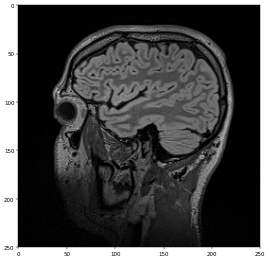

In [66]:
sitk_show(imgOriginal)

## Lissage / débruitage
Pour appliquer des algorithmes de segmentation de croissance de région et de seuillage, il faut une distribution de pixels plus lisse et plus homogène. 

> **CurvatureFlowImageFilter** implémente un algorithme de réduction du bruit d'image piloté par la courbure
parametres :
*   **numberOfIterations=5**  nombre d'itérations de mise à jour à effectuer      
*   **timeStep=0.125** pas de temps entre chaque mise à jour. Doit etre "suffisamment petit" pour garantir la stabilité numérique.












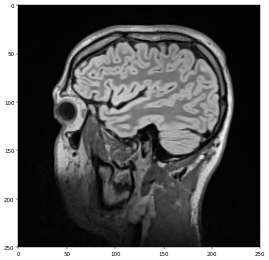

In [67]:
imgSmooth = SimpleITK.CurvatureFlow(image1=imgOriginal,
                                    timeStep=0.125,
                                    numberOfIterations=5)
# blurFilter = SimpleITK.CurvatureFlowImageFilter()
# blurFilter.SetNumberOfIterations(5)
# blurFilter.SetTimeStep(0.125)
# imgSmooth = blurFilter.Execute(imgOriginal)

sitk_show(imgSmooth)

## Segmentation ConnectedThresholdfiltre

> **ConnectedThresholdfiltre** Permet d'etiqueter les pixels qui sont connectés à une graine et se trouvant dans une plage de valeurs




### Segmentation initiale de la matière blanche

> **seedList** indice point de semance

> **Osirix** Visonneur d'image medical permet de constater que les pixels de la matière blanche présentent des valeurs compris entre [130, 190] definissant nos seuils

> **labelWhiteMatter** definit une valeur aux pixels appartenant au tissu de la matière blanche. Le reste mis à 0.








In [80]:
lstSeeds = [(150,75)] # indice point de semance (x, y, z)
imgWhiteMatter = SimpleITK.ConnectedThreshold(image1=imgSmooth, 
                                              seedList=lstSeeds, 
                                              lower=130, 
                                              upper=190,
                                              replaceValue=labelWhiteMatter)

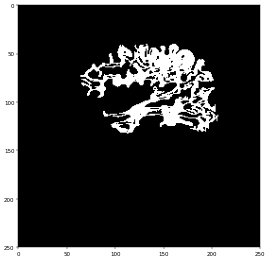

In [69]:
sitk_show(imgWhiteMatter)

###   Visualisation avec superposition d'étiquettes
imgSmooth, comprend des pixels avec des float tandis que imgWhiteMatter des valeurs de type int . Il faut «redimensionner» imgSmooth et le transtyper pour que les deux puissent correspondre.

> **RescaleIntensityImageFilter** : plage de valeurs par défaut de 0 et 255.

> **Cast** et **GetPixel** Redimensionner "imgSmooth" et le transformer en un type d'entier correspondant à celui de "imgWhiteMatter". 

In [70]:
imgSmoothInt = SimpleITK.Cast(SimpleITK.RescaleIntensity(imgSmooth), imgWhiteMatter.GetPixelID())

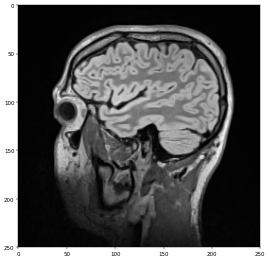

In [72]:
sitk_show(imgSmoothInt)

> **LabelOverlay** permet de superposer imgSmoothInt et à imgWhiteMatter. Ce qui crée une belle représentation RVB aux couleurs de base de la 2ème image qui est monochrome.

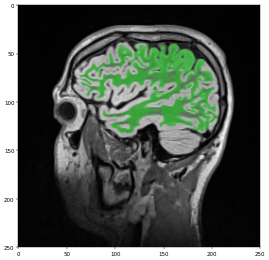

In [73]:
sitk_show(SimpleITK.LabelOverlay(imgSmoothInt, imgWhiteMatter))

### Remplissage des trous

> **VotingBinaryHoleFilling** : «Remplit les trous et les cavités en appliquant une opération de vote sur chaque pixel»

Le filtre vérifie chaque pixel "off", pixel d'arrière-plan (backgroundValue), et le règle sur une valeur d'avant-plan(foregroundValue) si la majorité des pixels qui l'entourent ont également une valeur d'avant-plan.

> **radius** La surface/le volume des pixels autour d'un trou qui est examiné.

> **majorityThreshold** Nombre de pixels de plus de 50% qui doivent être "activés" pour que ce pixel de trou soit "activé"









In [77]:
imgWhiteMatterNoHoles = SimpleITK.VotingBinaryHoleFilling(image1=imgWhiteMatter,
                                                          radius=[2]*3,
                                                          majorityThreshold=1,
                                                          backgroundValue=0,
                                                          foregroundValue=labelWhiteMatter)

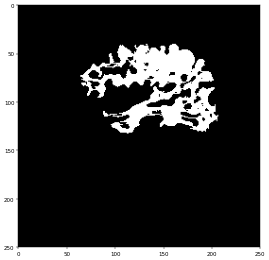

In [78]:
sitk_show(imgWhiteMatterNoHoles)

superposons à nouveau imgSmoothInt et imgWhiteMatterNoHoles

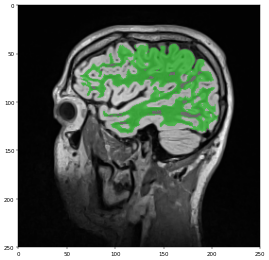

In [79]:
sitk_show(SimpleITK.LabelOverlay(imgSmoothInt, imgWhiteMatterNoHoles))

### Segmentation initiale de la matière grise

In [81]:
lstSeeds = [(119, 83), (198, 80), (185, 102), (164, 43)]
imgGrayMatter = SimpleITK.ConnectedThreshold(image1=imgSmooth, 
                                             seedList=lstSeeds, 
                                             lower=150, 
                                             upper=270,
                                             replaceValue=labelGrayMatter)

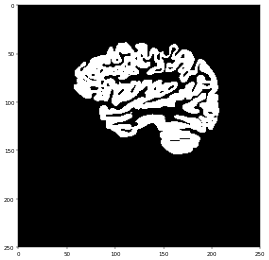

In [82]:
sitk_show(imgGrayMatter)

Remplissage des trous

In [83]:

imgGrayMatterNoHoles = SimpleITK.VotingBinaryHoleFilling(image1=imgGrayMatter,
                                                         radius=[2]*3,
                                                         majorityThreshold=1,
                                                         backgroundValue=0,
                                                         foregroundValue=labelGrayMatter)

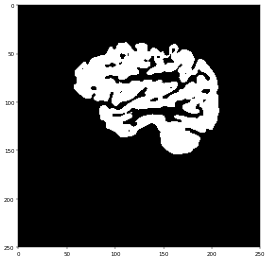

In [84]:
sitk_show(imgGrayMatterNoHoles)

Supperposons imgSmoothInt et  imgGrayMatterNoHoles

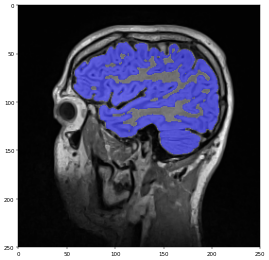

In [85]:
sitk_show(SimpleITK.LabelOverlay(imgSmoothInt, imgGrayMatterNoHoles))

### Combinaison des deux champs d'etiquettes, la matière blanche et grise.

> Opérateur OR ( |)





In [86]:
imgLabels = imgWhiteMatterNoHoles | imgGrayMatterNoHoles

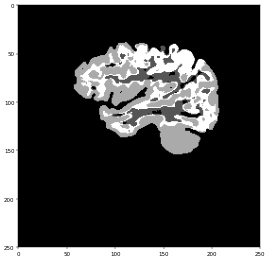

In [87]:
sitk_show(imgLabels)

Supperposition avec avec l'image filtré

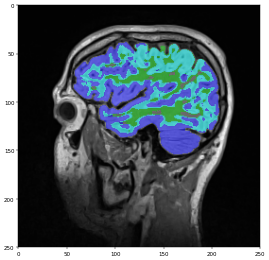

In [88]:
sitk_show(SimpleITK.LabelOverlay(imgSmoothInt, imgLabels))

## Affectation des zones communes à la matière grise
> la couleur cyan! representent les régions «revendiquées» à la fois par les étiquettes de matière blanche et de la matière blanche

>  la majorité de ces régions devraient faire partie de la matière grise


> **imgMask** une image «booléenne» contenant uniquement les régions communes des deux étiquettes


In [95]:
imgMask= imgWhiteMatterNoHoles * imgGrayMatterNoHoles

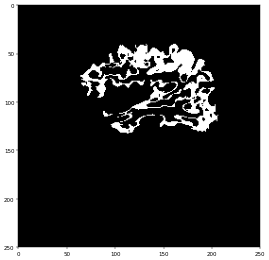

In [100]:
sitk_show(imgMask)

Multiplier les régions communes par labelWhiteMatter pour ramener ses valeurs à celles de l'étiquette de matière blanche, et soustaraire le résultat de imgWhiteMatterNoHoles. Laissant donc imgGrayMatterNoHoles ces régions).

In [96]:
imgWhiteMatterNoHoles -= 1000*imgMask*labelWhiteMatter

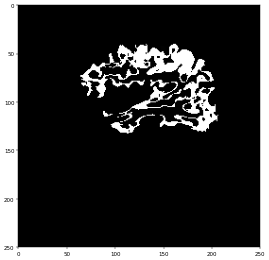

In [101]:
sitk_show(imgWhiteMatterNoHoles)

Recréer imgLabels en ajoutant imgWhiteMatterNoHoles et imgGrayMatterNoHoles

In [97]:
imgLabels = imgWhiteMatterNoHoles + imgGrayMatterNoHoles

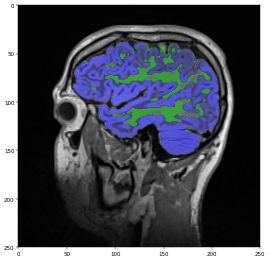

In [98]:
sitk_show(SimpleITK.LabelOverlay(imgSmoothInt, imgLabels))

### Visualiser les deux étiquettes sous forme de contours d'arêtes

> LabelContour 



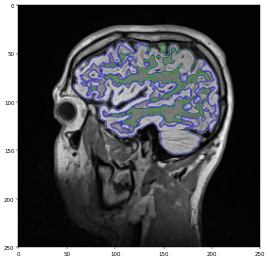

In [99]:
sitk_show(SimpleITK.LabelOverlay(imgSmoothInt, SimpleITK.LabelContour(imgLabels)))